Assignment 7: Transfer Learning
===============================


Microsoft Forms Document: https://forms.office.com/r/MvPiCwh6jR


Here, we use parts of the Fruits and Vegetables dataset that can be downloaded from Kaggle: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

For this small example, I have subselected some images, which are available here: https://seafile.ifi.uzh.ch/f/72e1d9c4ef20420eb1d9/?dl=1

First, we need to download and extract all our data.

In [ ]:
import os
dataset_zip_file = "fruits.zip"
if not os.path.exists(dataset_zip_file):
  import urllib.request
  urllib.request.urlretrieve("https://seafile.ifi.uzh.ch/f/72e1d9c4ef20420eb1d9/?dl=1", dataset_zip_file)
  print ("Downloaded datafile", dataset_zip_file)
  import zipfile
  zipfile.ZipFile(dataset_zip_file).extractall() ### extractall()方法会将 zip 文件的所有内容提取到当前工作目录

Task 1: Data Transformation
---------------------------

We need to instantiate a proper `torchvision.transform` instance to create the same input structure as used for training our network.
We need to combine 4 transforms, which can be compiled from the PyTorch website: https://pytorch.org/vision/stable/models.html

1. We need to resize the image such that the shorter side has size 256.
2. We need to take the center crop of size $224\times224$ from the image.
3. We need to convert the image into a tensor (including pixel values scaling)
4. We need to normalize the pixel values with mean $(0.485, 0.456, 0.406)$ and standard deviation $(0.229, 0.224, 0.225)

Since we will use networks pre-trained on ImageNet, we need to perform the exact same transform as used for ImageNet testing.

In [ ]:
from torchvision.transforms.transforms import ToTensor
import torch
import torchvision

imagenet_transform = torchvision.transforms.Compose([ ### 这里要用Compose，且有一个[] !!!!!!
    torchvision.transforms.Resize(256), ### 试试直接写Resize(256); 如果我写 ([256,256]) 也可以运行，但是会有一些小影响，比如acc会变？不知道具体有什么区别
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485,0.456,0.406),(0.229, 0.224, 0.225))
])

Task 2: Dataset Loading
-----------------------

We here use the `torchvision.datasets.ImageFolder` dataset interface for processing images. 
You can use its documented `is_valid_file` parameter to distinguish between training and test set.
The training files are all called `gallery.jpg` while test files are called `probe.jpg`.

Create two datasets, one for the training set, one for the test set. Use the transform defined above.

In [ ]:
trainset = torchvision.datasets.ImageFolder(
  root = "fruits", 
  transform = imagenet_transform,
  is_valid_file = lambda x : "gallery" in x  ### is_valid_file call-back function → Use to filter some files
)

testset = torchvision.datasets.ImageFolder(
  root = "fruits",
  transform = imagenet_transform,
  is_valid_file = lambda x : "probe" in x
)

Test 1: Data Size and Types
---------------------------

Check that all datasets contain the same number of images as classes.
Check that all input images are `torch.tensor`s of size $3\times224\times224$ and of type `torch.float`.


In [ ]:
assert(len(trainset) == len(testset))
print("len(trainset):",len(trainset))
for x,t in trainset + testset:    ### 为啥这里可以直接用加号？？？
  assert type(x) == torch.Tensor
  assert x.shape == (3,224,224)
  assert x.dtype == torch.float

len(trainset): 14


Task 3: Pre-trained Network
---------------------------

Instantiate a pre-trained network of type ResNet-18. 
Modify the network such that we extract the deep features from before the last fully-connected layer of the network.
For your reference, the implementation of the `forward` function of ResNet networks (including ResNet-18) can be found here: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L264

You can also check if other networks perform better, especially deeper ResNet topologies.
Be aware that our strategy to remove the last fully-connected layer might not work in other network topologies, only in residual networks.

Please Note: while we modify the `forward` function, we will still use the `__call__` function to extract our features.

In [ ]:
# instantiate pre-trained resnet 18 network
network = torchvision.models.resnet18(pretrained=True)
network.eval() ### model 的 test 开关，例如 Dropouts Layers、BatchNorm Layers 等会进入评估模式
from torchsummary import summary
summary(network,(3,224,224))
# make sure that deep features can be etxracted from the network
  # network.children() -> resnet 的每一层
  # network.children()[:-1] -> 去掉最后一层
  # list( network.children()[:-1] ) -> 把他们的type变成 list
  # *(list) 星号将 可迭代对象 扩展为 函数的参数列表 eg. a = [1,2,3] -> func(*a) == func(1,2,3)
network = torch.nn.Sequential( *( list( network.children() )[:-1] ) )
summary(network,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Task 4: Extract Features
------------------------

Implement a function that extracts all features for a given dataset.
Store the results in a dictionary: `target : feature`.
Extract the features for the training and the test set.

实现一个函数，提取给定数据集的所有特征。将结果存储在一个字典中：目标：特征。提取训练集和测试集的特征。

In [ ]:
def extract(network, dataset):
  features = {}
  with torch.no_grad(): # with torch.no_grad() 没有大的影响，但会运行更快一点
    for x,t in dataset:
      features[t] = network(x.unsqueeze(dim=0)) ### 模型接受4个参数 第一个是 batch-size 因为我们是逐个预测得，所以直接加一行啥都没有
  return features

train_features = extract(network,trainset)
test_features = extract(network,testset)

Test 2: Check your Features
---------------------------

Check that all your features are of dimension 512 and of datatype `torch.float` (larger ResNet topologies might have 2048-dimensional features).

In [ ]:
# check features
for v in train_features.values():
  print(v.shape)
  assert v.shape[1] == 512
  assert v.dtype == torch.float

torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])


Task 5: Similarity Computation
------------------------------

Iterate over all samples in the test set.
Compute the cosine similarities to all samples in the training set.
Store the similarity values in a matrix.

In [ ]:
O = len(testset)
similarities = torch.empty((O, O))
# compute similarities

# https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html
# >>> cos = nn.CosineSimilarity(dim=1, eps=1e-6)
# >>> output = cos(input1, input2)
# dim (int, optional) – Dimension where cosine similarity is computed. Default: 1
# eps (float, optional) – Small value to avoid division by zero. Default: 1e-8

cos = torch.nn.CosineSimilarity() ###### 注意这里的CosineSimilarity()要带括号！！！
for t, v in test_features.items():
  for t2, v2 in train_features.items():
    # similarities[t][t2] = torch.nn.CosineSimilarity()(v,v2)   ###### 这么写才对！！！！！
    similarities[t][t2] = cos(v,v2)
  # t = [0,1,2,3,4,5,6,7,8,9,10,11,12,13] 我也不知道这些 target 怎么来的，可能是dataset自动生成的

Task 6: Plot Similarity Values
------------------------------

Plot the similarity matrix as an image.

Text(0, 0.5, 'Testing class')

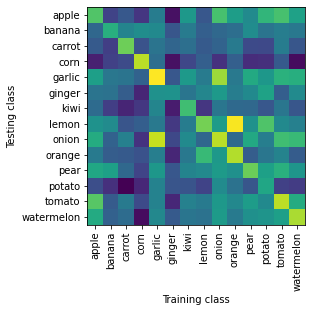

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# plot similarities
plt.imshow(similarities.detach().numpy())
classnames = sorted(os.listdir('fruits/'))
plt.xticks(np.arange(len(classnames)), classnames, rotation=90)
plt.yticks(np.arange(len(classnames)), classnames)
plt.xlabel('Training class')
plt.ylabel('Testing class')

Task 7: Classification Accuracy
-------------------------------

Compute the classification accuracy by checking if the class of highest similarity for a test sample is the correct class.

通过检查测试样本中相似度最高的类是否为正确的类来计算分类的准确性。

In [ ]:
# compute accuracy for our small test set

# correct = 0
# for row in range(O):
#   max_index = similarities[row].argmax()
#   if (max_index.item() == row):
#     correct += 1;
# accuracy = correct / O

same = similarities.argmax(dim=1) == torch.tensor(list(test_features.keys()))
accuracy = sum(same) / len(same)
print("Accuracy is", accuracy)

Accuracy is tensor(0.7857)


Task 8: Find Misclassified Images and Classes
----------------------------------------------

Find the test samples that are incorrectly classified. 
Get the class names (not only indexes) and write the names of the test sample class as well as the class that it was classified as.

What are the two most dissimilar classes?

In [ ]:
classnames = testset.classes ### 好像是根据 subfolder 寻找的，生成一个 list
print("classnames:",classnames)
# find all misclassified test images and print their real and predicted class name
real_keys = torch.tensor(list(test_features.keys()))
pred_keys = similarities.argmax(dim=1) ### 为什么答案给 dim=0 ？？？给错了，就应该是 dim=1
print(pred_keys)
print("\nall misclassified test images and print their real and predicted class name:")
for key in real_keys:
  if key != pred_keys[key]:
    print("Real:",classnames[key],"| predict:",classnames[pred_keys[key]])


# find the pair of most dissimilar training and test class and print their names

print("\nmost dissimilar training and test class and print their names:")
# 为什么矩阵的argmax返回的是一个整数？
idx = similarities.argmin().item()

row = idx // O
col = idx % O
print(classnames[row],"|",classnames[col])

classnames: ['apple', 'banana', 'carrot', 'corn', 'garlic', 'ginger', 'kiwi', 'lemon', 'onion', 'orange', 'pear', 'potato', 'tomato', 'watermelon']
tensor([ 0,  1,  2,  3,  4, 11,  6,  9,  4,  9, 10, 11, 12, 13])

all misclassified test images and print their real and predicted class name:
Real: ginger | predict: potato
Real: lemon | predict: orange
Real: onion | predict: garlic

most dissimilar training and test class and print their names:
potato | carrot


In [ ]:
similarities.argmax(dim=1)

tensor([ 0,  1,  2,  3,  4, 11,  6,  9,  4,  9, 10, 11, 12, 13])